In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from astropy.io import fits
import astropy.units as u

from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker
from gammapy.irf import Background3D

In [2]:
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
bdt_edges = cfg['bdt_edges']
energy_bins = np.logspace(-1,2, cfg['N_ebins']+1)
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
hessera='hess1'
conf=cfg['conf']
muoneff_flag= cfg['muoneff_flag']

In [3]:
runlist = [80170]
muoneff_path = f'{cfg["muoneff_path"]}/{hessera}/hess1_hess2/v01c_kaori_mueff'

basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
table = ds.obs_table
observations = ds.get_observations(runlist)

maker = MapDatasetMaker()

dataset_list = []
for obs in observations:
    # taking care of the correct bkg model (if it is muoneff or official model)
    # the official model is stored in the fits tables. For the muoneff model, we will just change the path of the bkg model
    if muoneff_flag:
        if obs.obs_info['MUONEFF'] > 0.085:
            model_CD = 'B'
        elif obs.obs_info['MUONEFF'] >= 0.075:
            model_CD = 'D'
        else:
            model_CD = 'C'

        if obs.obs_id >= 100000:
            run_number= f'{obs.obs_id}'
        else:
            run_number= f'0{obs.obs_id}'
        filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
        obs.bkg = Background3D.read(filename, hdu='BACKGROUND')

    geom = WcsGeom.create(skydir=obs.pointing_radec, binsz=cfg['binsz'], width=cfg['width']* u.deg, frame="icrs", axes=[axis])        
    dataset = MapDataset.create(geom=geom)
    dataset = maker.run(dataset, obs)

bg = fits.open(filename)
bins_model = np.concatenate((bg['BACKGROUND'].data['ENERG_LO'][0], [bg['BACKGROUND'].data['ENERG_HI'][0][-1]]))
data = np.sum(((bg['BACKGROUND'].data)['BKG'])[0], axis=(1,2))

No HDU found matching: OBS_ID = 80170, HDU_TYPE = rad_max, HDU_CLASS = None
Missing 'HDUCLAS2' keyword assuming 'BKG'


In [4]:
x_axis= geom.axes['energy'].center.value

In [17]:
coords = {"energy": geom.axes["energy"].edges.reshape((-1, 1, 1))}
bkg_de = np.sum(obs.bkg.integrate_log_log(**coords, axis_name="energy"), axis=(1,2))

real_list = []
for j in range(24):
    delta_x = energy_bins[j+1]-energy_bins[j]
    bkg_de[j] /=delta_x
    real=0
    for i in range(len(bins_model)-1):
        aux=0
        if bins_model[i+1] >= energy_bins[j] and bins_model[i]<= energy_bins[j]:
            aux=data[i]*(bins_model[i+1]-energy_bins[j])/delta_x
        elif bins_model[i+1] >= energy_bins[j+1] and bins_model[i]<= energy_bins[j+1]:
            aux=data[i]*(energy_bins[j+1]-bins_model[i])/delta_x
        elif bins_model[i+1] <= energy_bins[j+1] and bins_model[i]>= energy_bins[j]:
            aux=data[i]*(bins_model[i+1]-bins_model[i])/delta_x
        real+=aux
    real_list.append(real)

Text(0.5, 1.0, 'different energy binning')

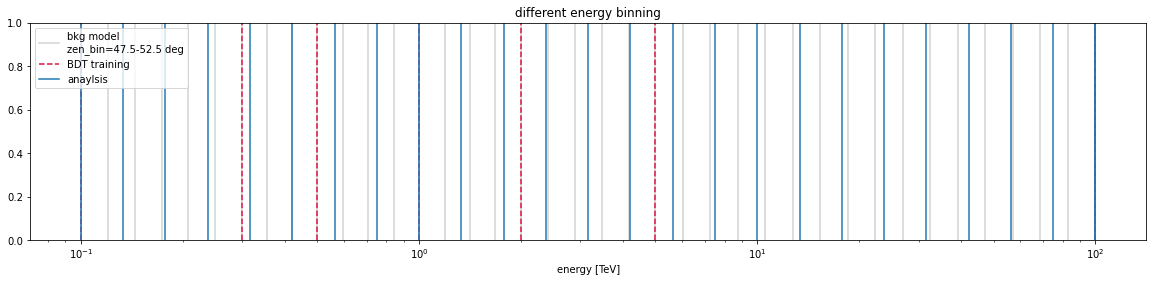

In [5]:
plt.figure(figsize=(20,4))    

#plt.hist(bins_model[:-1], bins=bins_model, weights=np.sum(obs.bkg.data, axis=(1,2)), color='gold', label='bkg data model', histtype='step')
#plt.yscale('log')
#plt.scatter(x_axis, a, color='C2', label='integral from gammapy')

for e in bins_model:
    plt.axvline(e, color='lightgray')
plt.axvline(e, color='lightgray', label='bkg model\nzen_bin=47.5-52.5 deg')

for bdt in bdt_edges:
    plt.axvline(bdt, ls='--', color='crimson')
plt.axvline(bdt, ls='--', color='crimson', label='BDT training')

for e in energy_bins:
    plt.axvline(e)
plt.axvline(e, label='anaylsis')

plt.legend()
plt.xscale('log')
plt.xlabel('energy [TeV]')
plt.title('different energy binning')

Text(0.5, 1.0, 'bkg model from construction')

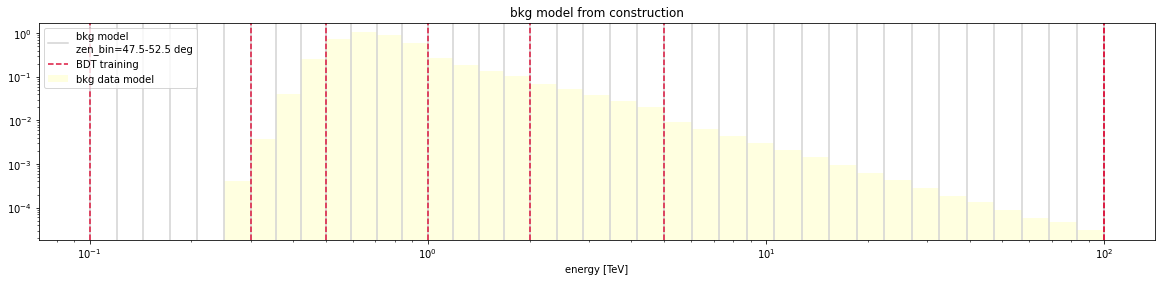

In [6]:
plt.figure(figsize=(20,4))    

plt.hist(bins_model[:-1], bins=bins_model, weights=np.sum(obs.bkg.data, axis=(1,2)), color='lightyellow', label='bkg data model')
plt.yscale('log')
#plt.scatter(x_axis, a, color='C2', label='integral from gammapy')

for e in bins_model:
    plt.axvline(e, color='lightgray')
plt.axvline(e, color='lightgray', label='bkg model\nzen_bin=47.5-52.5 deg')

for bdt in bdt_edges:
    plt.axvline(bdt, ls='--', color='crimson')
plt.axvline(bdt, ls='--', color='crimson', label='BDT training')

# for e in energy_bins:
#     plt.axvline(e)
# plt.axvline(e, label='anaylsis')


plt.legend()
plt.xscale('log')
plt.xlabel('energy [TeV]')
plt.title('bkg model from construction')

Text(0.5, 1.0, 'comparison of gammapy bkg prediction with analysis bin')

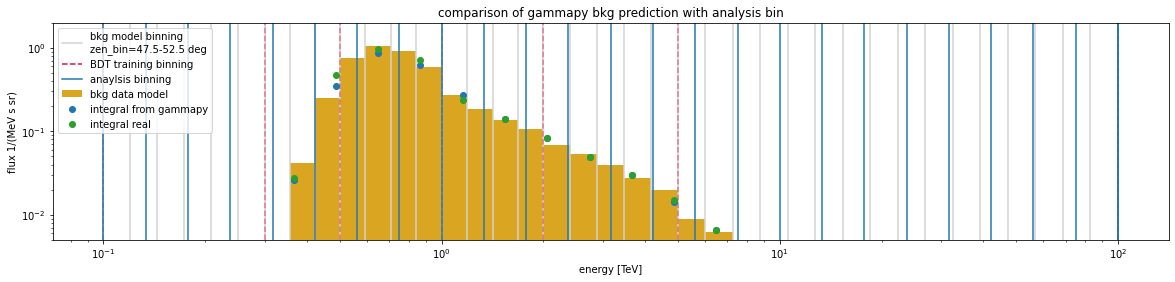

In [37]:
plt.figure(figsize=(20,4))    

plt.hist(bins_model[:-1], bins=bins_model, weights=np.sum(obs.bkg.data, axis=(1,2)), color='goldenrod', label='bkg data model')
plt.yscale('log')


for e in bins_model:
    plt.axvline(e, color='lightgray')
plt.axvline(e, color='lightgray', label='bkg model binning\nzen_bin=47.5-52.5 deg')

for bdt in bdt_edges:
    plt.axvline(bdt, ls='--', color='crimson', alpha=0.5)
plt.axvline(bdt, ls='--', color='crimson', label='BDT training binning')

for e in energy_bins:
    plt.axvline(e)
plt.axvline(e, label='anaylsis binning')

plt.scatter(x_axis, bkg_de, color='C0', label='integral from gammapy', zorder=4)
plt.scatter(x_axis, real_list, color='C2', label='integral real', zorder=4)


plt.legend()
plt.xscale('log')
plt.xlabel('energy [TeV]')
plt.ylabel('flux 1/(MeV s sr)')
plt.ylim(5e-3, 2)

plt.title('comparison of gammapy bkg prediction with analysis bin')

Text(0.5, 1.0, 'values in analysis energy bin')

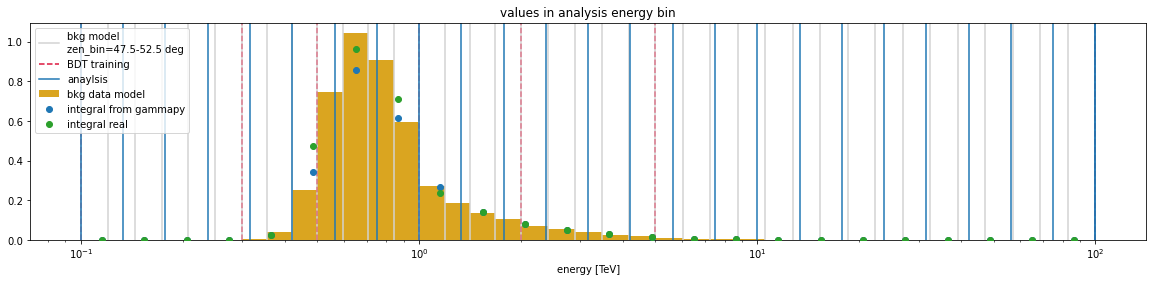

In [21]:
plt.figure(figsize=(20,4))    

plt.hist(bins_model[:-1], bins=bins_model, weights=np.sum(obs.bkg.data, axis=(1,2)), color='goldenrod', label='bkg data model')
#plt.yscale('log')


for e in bins_model:
    plt.axvline(e, color='lightgray')
plt.axvline(e, color='lightgray', label='bkg model\nzen_bin=47.5-52.5 deg')

for bdt in bdt_edges:
    plt.axvline(bdt, ls='--', color='crimson', alpha=0.5)
plt.axvline(bdt, ls='--', color='crimson', label='BDT training')

for e in energy_bins:
    plt.axvline(e)
plt.axvline(e, label='anaylsis')

plt.scatter(x_axis, bkg_de, color='C0', label='integral from gammapy', zorder=4)
plt.scatter(x_axis, real_list, color='C2', label='integral real', zorder=4)


plt.legend()
plt.xscale('log')
plt.xlabel('energy [TeV]')
plt.title('values in analysis energy bin')

/tmp/ipykernel_32748/1660874714.py:2: RuntimeWarning: invalid value encountered in double_scalars
  value=100*((real_list-bkg_de.value)[i])/bkg_de.value[i]


Text(0.5, 0, 'energy')

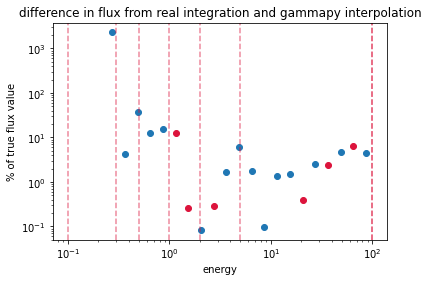

In [43]:
for i in range(24):
    value=100*((real_list-bkg_de.value)[i])/bkg_de.value[i]
    if value >0:
        plt.scatter(x_axis[i], value, color='C0')
    else:
        plt.scatter(x_axis[i], abs(value), color='crimson')
        
for bdt in bdt_edges:
    plt.axvline(bdt, ls='--', color='crimson', alpha=0.5)
plt.axvline(bdt, ls='--', color='crimson', label='BDT training', alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('% of true flux value')
plt.title('difference in flux from real integration and gammapy interpolation')
plt.xlabel('energy')